## Machine Learning Final Project
> Aaron Floreani

> ITP 449, Section: 31854

> May 7th, 2021


## **Forecasting Bitcoin Prices via ARIMA, XGBOOST, and PROPHET, and LSTM**
- Google Drive Dataset Link: https://drive.google.com/file/d/1hf7LoME8BEm7PjNP4tBOeHbcNiIgF558/view?usp=sharing
- This Notebook Link: https://colab.research.google.com/drive/1ZVUnWVMRRT_2Iy2rkVWUrzX_HdQtQXuq?usp=sharing
- Github Repo: https://github.com/AaronFlore/Forecasting_BitcoinPrices
- Medium Blog: https://floreani.medium.com/how-well-can-machine-learning-models-predict-the-price-of-bitcoin-f036fdecdc03
- Kaggle Dataset: https://www.kaggle.com/mczielinski/bitcoin-historical-data

**Table of Contents**
- This notebook will be broken down into 6 sections:
1. EDA
2. PROPHET
3. ARIMA
4. LSTM
5. XGBOOST
5. CONCLUSION (Comparing each model's RMSE)

**Standarized Procedure for Testing Models**
- Each model will be trained on the first 70% of the data and tested on the last 30%. The bitcoin data will be resampled to days and restricted to the past 4 years only (from March 31st, 2021).
- The Root Mean Square Error (RMSE) of each model will determine which is the best.

**1. Exploratory Data Analysis**

Besides a recent 3 months of data added to this Bitcoin csv, I've already explored this data in my past notebook. My EDA Project: https://colab.research.google.com/drive/1DDmCoN_9448mNi-T0oVemC-5i-17uR5w?usp=sharing

In [150]:
# import libararies
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

In [151]:
# read the dataset into a dataframe
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
# Start of cleaning the data. Converting Timestamp to datetime64
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
# sets the index as the date
df.index = df.Timestamp
# Resample the data to the average daily value of each column. Removes excessive frequency
df = df.resample('D').mean()
# drops any missing values that are present
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [153]:
print(df.shape)
# Now we have 3,376 rows instead of 4 million - with no missing valeus and accurate datetime information

(3376, 7)


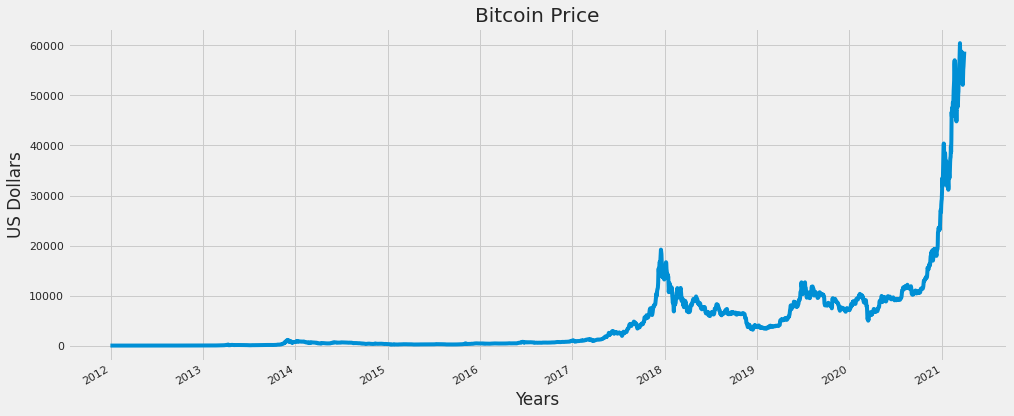

In [154]:
# graph bitcoin price over the years
df.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()
# As the graph show 2017-2021 is signficantly different than 2012 - 2017

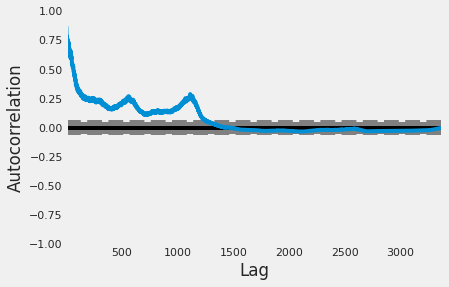

In [155]:
# Plot the autocorrelation to see if there are a large number of lags in the time series.
autocorrelation_plot(df)
plt.show()

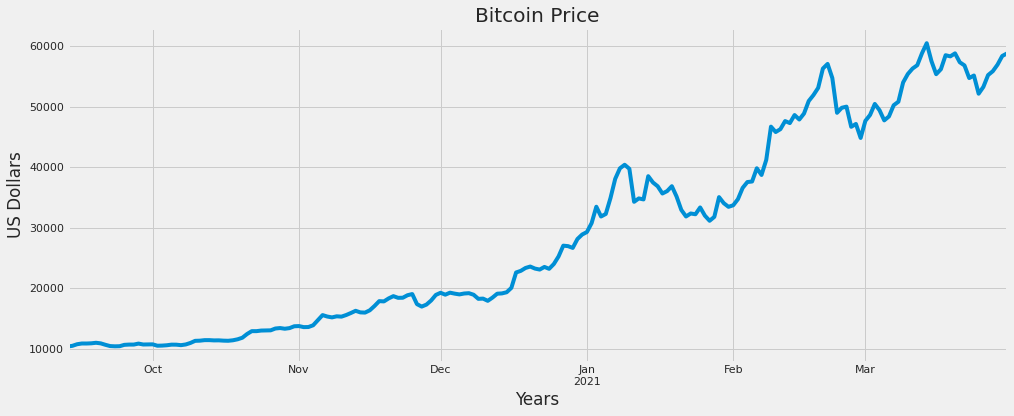

In [156]:
# let's look at the past 200 days for possibly adjust our data
df.Weighted_Price.iloc[-200:].plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()

In [157]:
# Since the first couple years of bitcoin didn't properly represent the movement in the price of it.
# I decide to simply focus on the previous 4 years of data from March 31st, 2021.
df2 = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df2.Timestamp = pd.to_datetime(df2.Timestamp, unit='s')
df2.index = df2.Timestamp
df2 = df2.resample('D').mean()
df2 = df2.dropna()
# changes data to strictly to the previous 4 years, which is March 2017 to March 2021
df2 = df2.iloc[(-365*4):]
print(df2.shape)

(1460, 7)


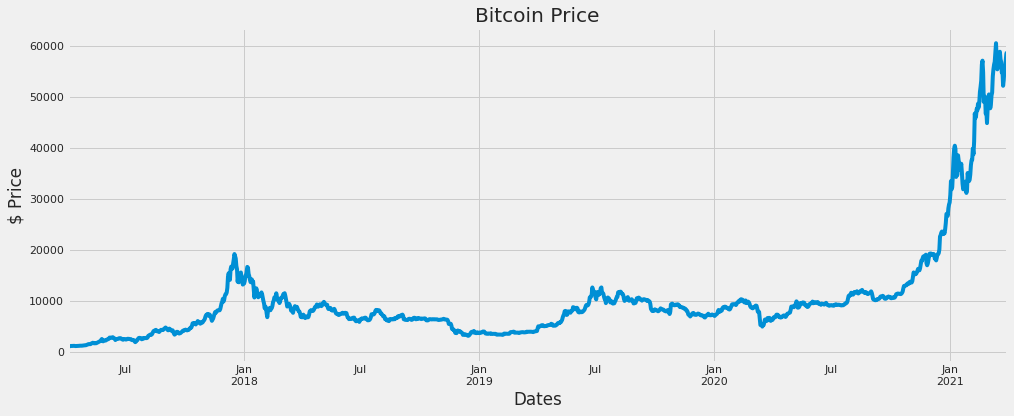

In [158]:
df2.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Dates')
plt.ylabel('$ Price')
plt.show()
# This data looks much more relevant for training a model. 
# However the recent spike will be involved in the testing data split.

**1A. ROLLING FORECAST ARIMA**

The first model I chose to apply was a rolling forecast ARIMA model. I'm using this model to get a baseline for my RMSE. However, since this model predicts in day by day increments, it isn't fair to compare to the other models. 


In [159]:
from statsmodels.tsa.arima_model import ARIMA
# We're going to create a dataframe for just the price (the index is still the date)
price = df2.Weighted_Price
# Next we're going to assign 70% percent of the data to training and 30% for testing
X = price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

predicted=8912.596773, expected=8891.817032
predicted=8901.310100, expected=8847.166822
predicted=8829.399030, expected=8644.708000
predicted=8621.006420, expected=8646.193567
predicted=8650.673922, expected=8665.685486
predicted=8679.169601, expected=8435.602730
predicted=8387.291168, expected=8383.325487
predicted=8385.383509, expected=8321.535236
predicted=8324.188677, expected=8430.129200
predicted=8446.908529, expected=8723.535467
predicted=8794.199953, expected=9041.676236
predicted=9105.140008, expected=9331.033358
predicted=9391.745814, expected=9370.896512
predicted=9384.943957, expected=9342.279203
predicted=9339.154953, expected=9372.449066
predicted=9387.640327, expected=9377.036114
predicted=9377.893611, expected=9330.400381
predicted=9323.867659, expected=9202.938405
predicted=9186.485232, expected=9403.167151
predicted=9450.468354, expected=9689.417025
predicted=9754.614495, expected=9776.736693
predicted=9788.455859, expected=9813.044906
predicted=9831.224742, expected=

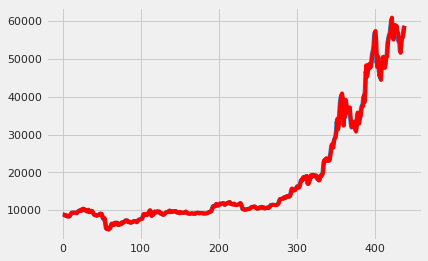

In [160]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 914.737


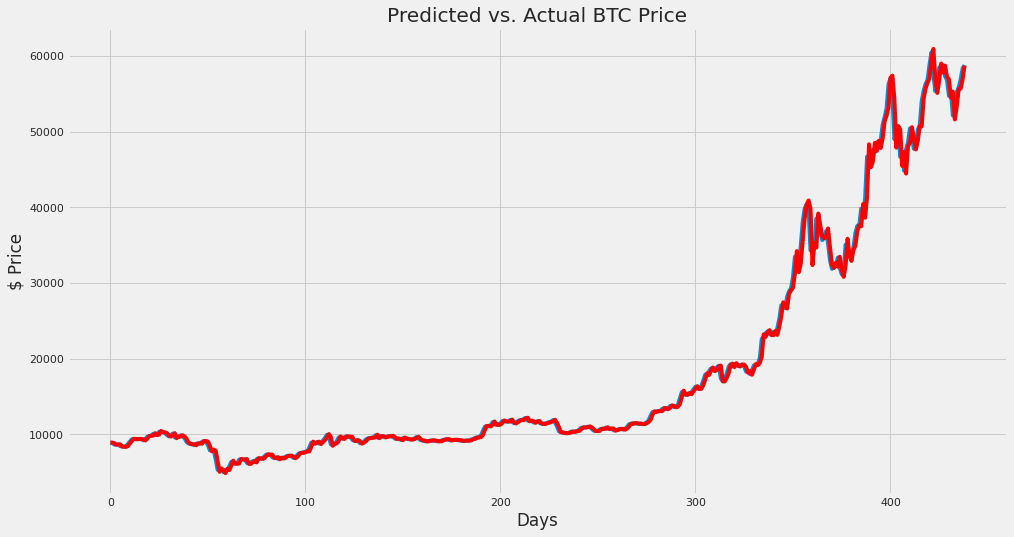

In [161]:
# if we look at this model, the predicted is indistinuishable from the actual price
# this is simply because it's predicting day by day.
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Actual BTC Price')
plt.show()

Test RMSE: 914.737


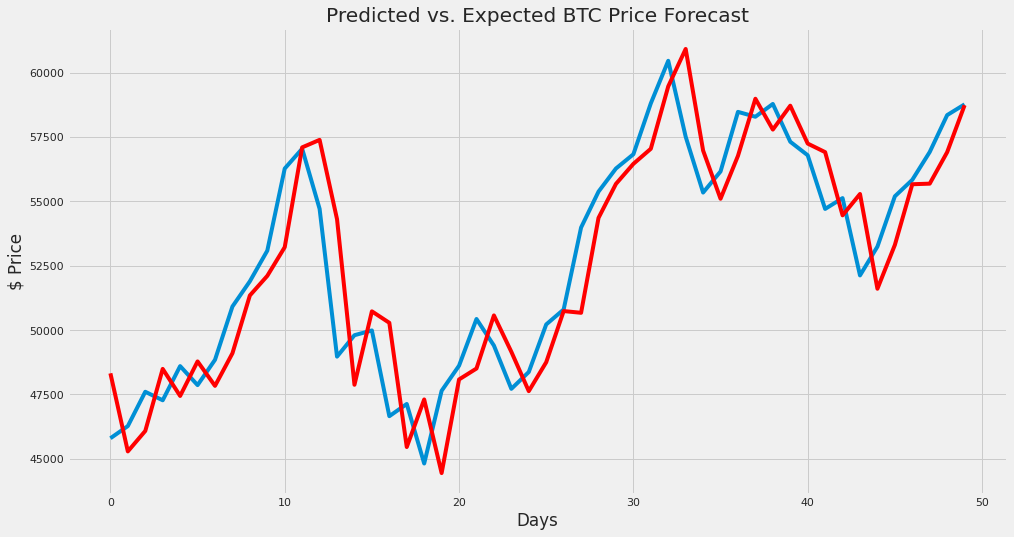

In [162]:
# I plot 50 days to more accurately see how the models works with its lag
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test[-50:])
plt.plot(predictions[-50:], color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Expected BTC Price Forecast')
plt.show()

**2. PROPHET**

In [163]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [164]:
# For prophet we have to fit the dataframe to two columns: ds, y
df3 = df2.copy()
df3.reset_index(inplace=True)
df3 = df3[['Timestamp', 'Weighted_Price']]
df3.columns = ['ds', 'y']
# Next the data is split as usual
X = df3
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

In [165]:
model = Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [166]:
# frequency is a day and periods are length of test data
future = model.make_future_dataframe(periods=len(test), freq='D')
forecasting = model.predict(future)
# prediction is stored and RMSE is returned
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 24810.845


In [167]:
forecasting.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-04-02,2966.046718,-519.167182,1759.945593,2966.046718,2966.046718,-2292.465222,-2292.465222,-2292.465222,-1.972570,-1.972570,-1.972570,-2290.492652,-2290.492652,-2290.492652,0.0,0.0,0.0,673.581496
1,2017-04-03,2962.683587,-531.622261,1939.332936,2962.683587,2962.683587,-2227.401209,-2227.401209,-2227.401209,19.142063,19.142063,19.142063,-2246.543272,-2246.543272,-2246.543272,0.0,0.0,0.0,735.282378
2,2017-04-04,2959.320455,-485.329428,2033.788209,2959.320455,2959.320455,-2184.884729,-2184.884729,-2184.884729,16.783066,16.783066,16.783066,-2201.667795,-2201.667795,-2201.667795,0.0,0.0,0.0,774.435726
3,2017-04-05,2955.957324,-385.343001,2059.779978,2955.957324,2955.957324,-2155.359640,-2155.359640,-2155.359640,1.418398,1.418398,1.418398,-2156.778037,-2156.778037,-2156.778037,0.0,0.0,0.0,800.597684
4,2017-04-06,2952.594193,-375.888909,2028.004893,2952.594193,2952.594193,-2137.939449,-2137.939449,-2137.939449,-25.264608,-25.264608,-25.264608,-2112.674842,-2112.674842,-2112.674842,0.0,0.0,0.0,814.654743


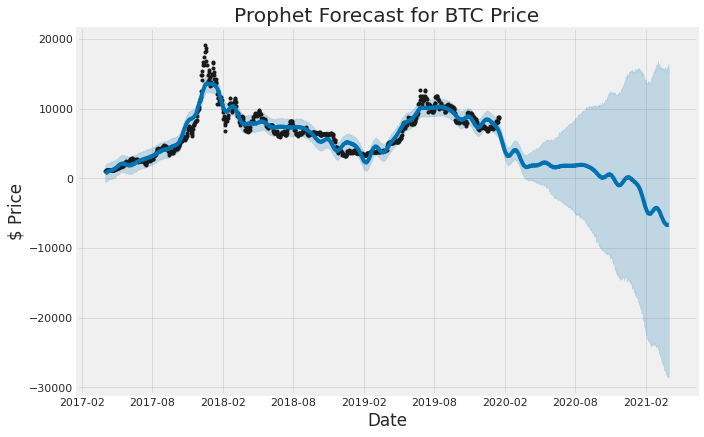

In [168]:
# Plotting forecast
model.plot(forecasting)
plt.title('Prophet Forecast for BTC Price')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.show()

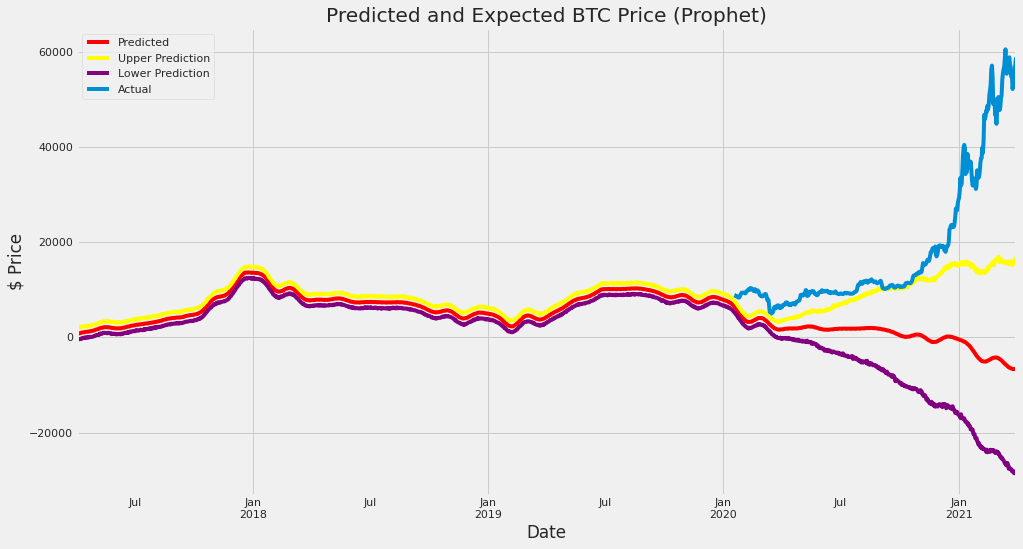

In [170]:
# Plotting forecast with test data
ax = forecasting.plot(x='ds', y='yhat', legend=True, label="Predicted", figsize=(15,8), color='red')
forecasting.plot(x='ds', y='yhat_upper', legend=True, label='Upper Prediction', ax=ax, color='yellow')
forecasting.plot(x='ds', y='yhat_lower', legend=True, label='Lower Prediction', ax=ax, color='purple')
test.plot(x='ds', y='y', legend=True, label='Actual', ax=ax)
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.title('Predicted and Expected BTC Price (Prophet)')
plt.legend(loc='best')
plt.show()

**3. ARIMA MODEL**

In [171]:
from statsmodels.tsa.arima_model import ARIMA
# method to be used later
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [172]:
print(len(test))

439


In [173]:
#Split the data as usual 70, 30
price = df2.Weighted_Price
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365
plotDates = datesX[size:len(X)]

# Next we will forecast with ARIMA using 5,1,0
differenced = difference(train, days_in_year)
model = ARIMA(differenced, order=(5, 1, 0))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 438
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

# store predicted results 
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print("Predicted Day %d: %f" % (day, inverted))
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1


Predicted Day 1: 3678.990151
Predicted Day 2: 3690.581677
Predicted Day 3: 3595.140410
Predicted Day 4: 3545.489350
Predicted Day 5: 3552.930489
Predicted Day 6: 3568.264511
Predicted Day 7: 3552.771251
Predicted Day 8: 3556.257188
Predicted Day 9: 3570.942588
Predicted Day 10: 3543.900798
Predicted Day 11: 3436.112741
Predicted Day 12: 3397.173197
Predicted Day 13: 3423.266732
Predicted Day 14: 3423.542413
Predicted Day 15: 3415.839811
Predicted Day 16: 3431.352466
Predicted Day 17: 3424.074313
Predicted Day 18: 3413.189924
Predicted Day 19: 3418.568913
Predicted Day 20: 3370.529035
Predicted Day 21: 3365.429129
Predicted Day 22: 3455.054342
Predicted Day 23: 3614.102230
Predicted Day 24: 3607.106587
Predicted Day 25: 3594.385591
Predicted Day 26: 3577.125253
Predicted Day 27: 3581.225009
Predicted Day 28: 3568.072830
Predicted Day 29: 3569.695640
Predicted Day 30: 3586.926314
Predicted Day 31: 3584.538609
Predicted Day 32: 3755.924809
Predicted Day 33: 3899.983148
Predicted Day 34: 3

In [174]:
rmse = np.sqrt(mean_squared_error(test, predicted_results))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19633.653


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  655
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4862.648
Method:                       css-mle   S.D. of innovations            405.410
Date:                Sat, 08 May 2021   AIC                           9739.296
Time:                        02:47:03   BIC                           9770.688
Sample:                             1   HQIC                          9751.468
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7486     21.291     -0.035      0.972     -42.478      40.981
ar.L1.D.y      0.2159      0.039      5.529      0.000       0.139       0.292
ar.L2.D.y      0.0256      0.040      0.643      0.5

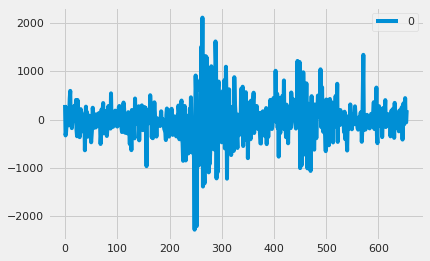

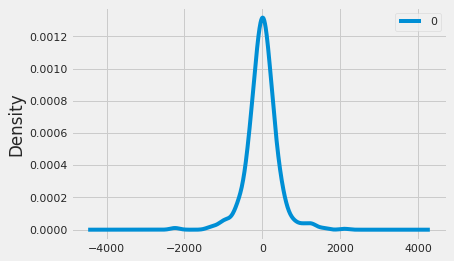

                 0
count   655.000000
mean     -0.085407
std     405.730523
min   -2280.438591
25%    -195.522129
50%       7.403682
75%     194.269531
max    2110.072294


In [175]:
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

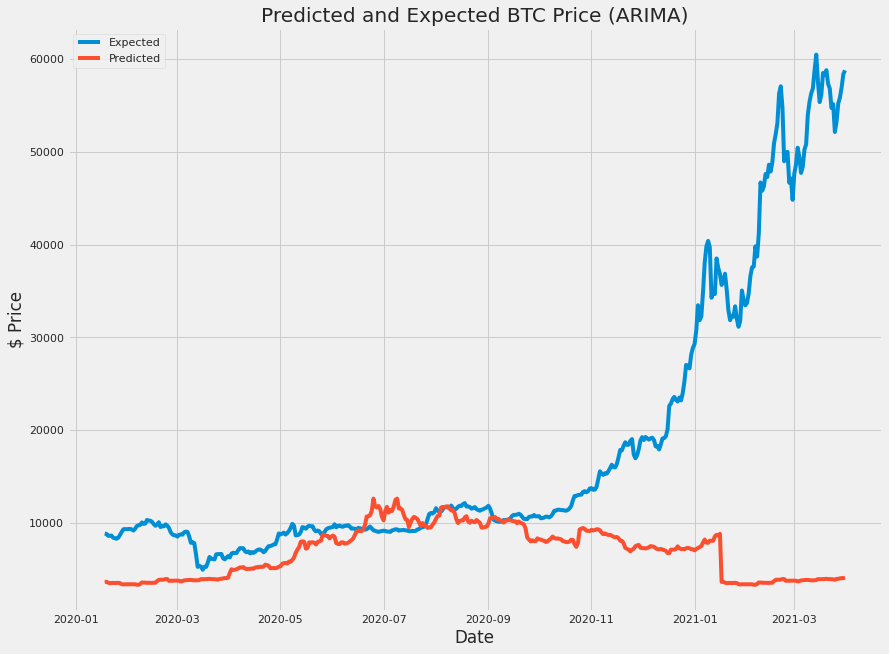

In [176]:
plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predicted_results, label='Predicted')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.title('Predicted and Expected BTC Price (ARIMA)')
plt.show()

**4. LSTM**

In [194]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [195]:
price = df2.Weighted_Price
# As usual split data, 70, 30
X = price
size = int(len(X) * 0.7)
train_df, test_df = X[0:size], X[size:len(X)]
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

#Scale the data using minMaxScaler
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
# assign training values
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [196]:
# creates model
model = Sequential()
model.add(LSTM(10,input_shape = (None,1), activation="relu", return_sequences=True))
model.add(Dense(1))

In [197]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [198]:
# fit the model to the training data
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 0.0982
Epoch 2/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0676
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0243
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 6/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 11/50
32/32 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 12/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 13/50
32/32 [==============================

In [199]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = np.reshape(predicted_price, (len(predicted_price), 1))
predicted_price = scaler.inverse_transform(predicted_price)

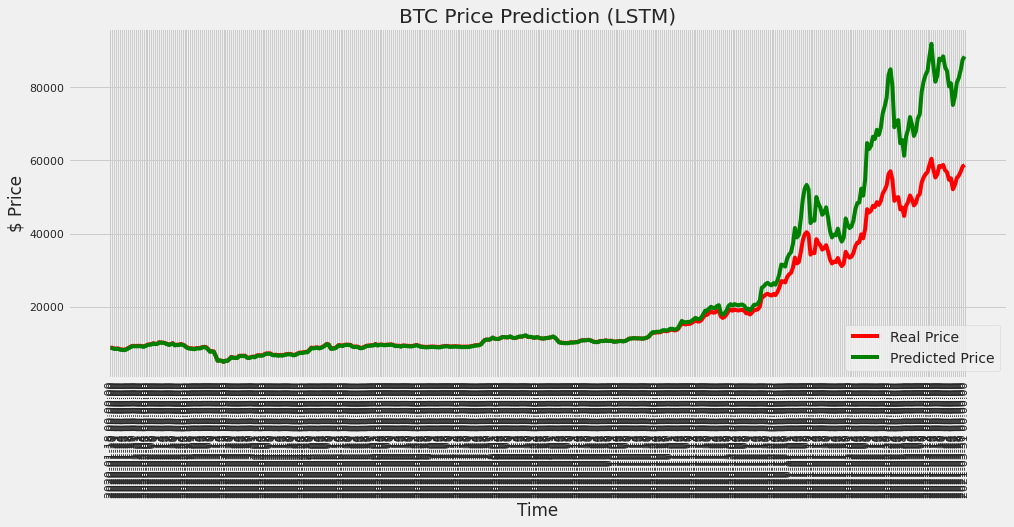

In [200]:
# ploting the results
plt.figure(figsize=(15, 6))
ax = plt.gca()  
plt.plot(test_df.values, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction (LSTM)')
test_df = test_df.reset_index()
x= test_df.index
labels = test_df['Timestamp']
plt.xticks(x, labels, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel('$ Price')
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [201]:
rmse = np.sqrt(mean_squared_error(test_df.Weighted_Price.values, predicted_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8688.871


**5. XGBOOST MODEL**

In [206]:
# splitting data again, 70, 30
df5 = df2.copy()
X = df5
size = int(len(X) * 0.7)
data_train, data_test = X[0:size], X[size:len(X)]

In [207]:
# a method to create a variety of features from a time series df
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [208]:
# assigning training and testing, features and labels (price)
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [209]:
# import XGBoost, then create model, and fit it to the training data
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

[02:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [216]:
# assign predictions to data_test and then data_all
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



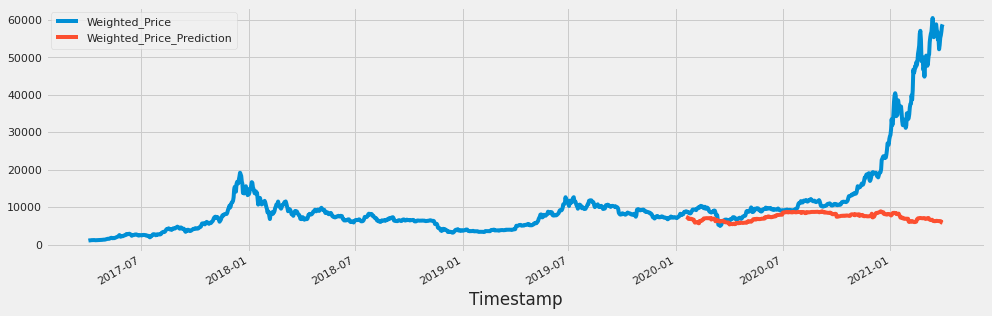

In [217]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [218]:
data_test.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weighted_Price_Prediction
Timestamp,,,,,,,,,,,,,,,,,
2020-01-18,8891.207561,8895.987338,8886.848700,8890.932203,2.555948,22739.596158,8891.817032,2020-01-18,0,5,1,1,2020,18,18,3,7409.640137
2020-01-19,8846.440862,8852.059917,8841.301460,8846.728456,6.109492,53655.111012,8847.166822,2020-01-19,0,6,1,1,2020,19,19,3,7337.379395
2020-01-20,8644.165698,8648.276386,8640.256435,8644.101508,3.071715,26529.821802,8644.708000,2020-01-20,0,0,1,1,2020,20,20,4,7246.419922
2020-01-21,8645.480195,8649.571579,8642.046356,8645.604819,2.360702,20386.559122,8646.193567,2020-01-21,0,1,1,1,2020,21,21,4,7198.488281
2020-01-22,8665.194124,8668.595431,8662.189026,8665.453755,2.186239,18933.853843,8665.685486,2020-01-22,0,2,1,1,2020,22,22,4,6861.897949


In [219]:
rmse = np.sqrt(mean_squared_error(data_test['Weighted_Price'], data_test['Weighted_Price_Prediction']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18483.212


**6. Conclusion**

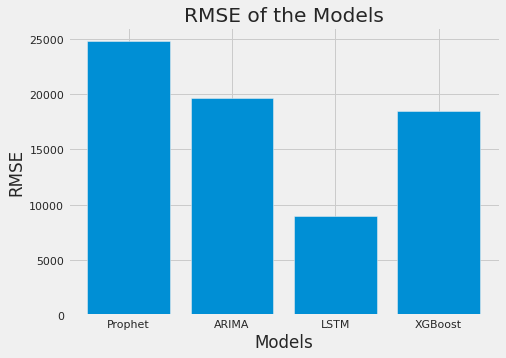

In [220]:
# Final graph for the RMSE's of each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
modelz = ['Prophet', 'ARIMA', 'LSTM', 'XGBoost']
nums = [24810,19633,8950, 18483]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.show()
plt.show()